In [1]:
import time
import os
import subprocess
import sys
import re
import argparse
import collections
import gzip
import math
import shutil
import matplotlib.pyplot as plt
import wandb
import numpy as np
import time
from datetime import datetime
import random

import seaborn as sns
%matplotlib inline
import logging
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import tensorflow as tf

import tensorflow.experimental.numpy as tnp
import tensorflow_addons as tfa
from tensorflow import strings as tfs
from tensorflow.keras import mixed_precision
from scipy.stats.stats import pearsonr  
from scipy.stats.stats import spearmanr  
## custom modules
import src.aformer_TF_gc_separated as aformer
#import src.aformer_TF as aformer
from src.layers.layers import *
import src.metrics as metrics
from src.optimizers import *
import src.schedulers as schedulers
import src.utils as utils

import training_utils_aformer_TF_genecentered_separated as training_utils


from scipy import stats

#os.environ['TF_ENABLE_EAGER_CLIENT_STREAMING_ENQUEUE']='False'



/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [2]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='node-15')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

with strategy.scope():
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
    options.deterministic=False
    #options.experimental_threading.max_intra_op_parallelism = 1
    mixed_precision.set_global_policy('mixed_bfloat16')
    tf.config.optimizer.set_jit(True)
    #options.num_devices = 64

    BATCH_SIZE_PER_REPLICA = 8
    NUM_REPLICAS = strategy.num_replicas_in_sync
    GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * NUM_REPLICAS

In [3]:
with strategy.scope():

    train_steps=50#3200#5165 #320
    warmup_steps=10
    val_steps_h=105#3200#757 ### 5562
    val_steps_m=14
    num_epochs=20
    lr_base=0.001
    warmup_lr=1.0e-06

    data_it_tr_list = []
    data_it_val_list = []

    ### create dataset iterators
    heads_dict = {}
    orgs = ["hg","mm"]
    for k, org in enumerate(orgs):
        heads_dict[org] = int(k)
    data_dict_tr,data_dict_val = training_utils.return_distributed_iterators(heads_dict,
                                                                             "gs://picard-testing-176520/262k_genecentered_blacklist0.50_atacnormalized/preprocessed",
                                                                              GLOBAL_BATCH_SIZE,
                                                                              262144,
                                                                              300,
                                                                              "logTPM",
                                                                              4,
                                                                              num_epochs,
                                                                              strategy,
                                                                              options)

In [4]:
with strategy.scope():
    model = aformer.aformer(kernel_transformation="softmax_kernel_transformation",
                                dropout_rate=0.25,
                                input_length=65536,
                                num_heads=4,
                                numerical_stabilizer=0.0000001,
                                nb_random_features=256,
                                hidden_size=256,
                                d_model=256,
                                norm=True,
                                dim=64,
                                max_seq_length = 2048,
                                rel_pos_bins=2048,
                                widening = 2, ## ratio between first and second dense layer units in transformer block
                                conv_filter_size_1_seq=15,
                                conv_filter_size_2_seq=5,
                                conv_filter_size_1_atac=15,
                                conv_filter_size_2_atac=5,
                                positional_dropout_rate=0.1,
                                transformer_depth=2,
                                momentum=0.90,
                                channels_list=[96,96,112,112,128,128], 
                                kernel_regularizer=0.0000001,
                                bottleneck_units=64,
                            bottleneck_units_tf=64,
                                use_mask_pos=False,
                                use_rot_emb=True,
                                heads_dict=heads_dict)
    

In [5]:
with strategy.scope():
    """
    optimizer = tfa.optimizers.AdaBelief(learning_rate=0.0005,
                                         weight_decay=5.0e-08,
                                         warmup_proportion=0.01,
                                         epsilon=1e-10,
                                         rectify=True,
                                         min_lr=0.00001,
                                         total_steps=100000)
    
    
    lr_schedule = WarmUp(initial_learning_rate = 0.01,
                         decay_schedule_fn=tf.keras.optimizers.schedules.CosineDecayRestarts(
                                                                    0.01,
                                                                    200,
                                                                    t_mul=2.0,
                                                                    m_mul=0.8,
                                                                    alpha=0.0,
                                                                    name=None),
                         warmup_steps=100)
    """
    optimizer =AdafactorOptimizer()
    optimizer=tfa.optimizers.Lookahead(optimizer, 
                                                     sync_period=6,
                                                     slow_step_size=0.5)
    

In [6]:
with strategy.scope():
    metric_dict = {}
    train_step, val_step, metric_dict = training_utils.return_train_val_functions_hg_mm(model,
                                                                                 optimizer,
                                                                                 strategy,
                                                                                 metric_dict, 
                                                                                 train_steps,
                                                                                 val_steps_h,
                                                                                 val_steps_m,
                                                                                 GLOBAL_BATCH_SIZE,
                                                                                 0.2,
                                                                                 True,
                                                                                 freq_limit=5000,
                                                                                 fourier_loss_scale=1.0) # last is uncropped length


In [7]:
%matplotlib inline

hg_train_loss: 1.8122354
hg_val_loss: 1.6675785
hg_val_pearson: 0.20478547
hg_val_R2: [-1.0178797]
mm_val_pearson: 0.2851018
mm_val_R2: [-0.06367576]
overall gene pearsonsR: 0.20478545515419633
overall gene spearmanR: 0.2680393813965069


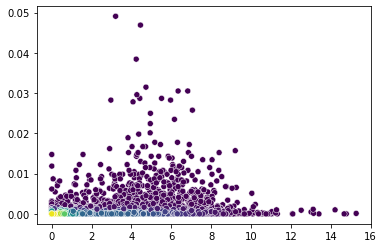

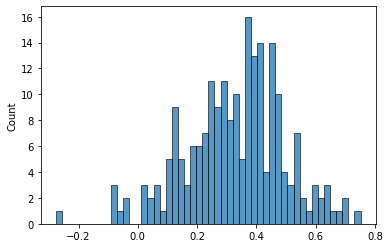

median_cell_crossgenes: 0.34155667519712174


/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


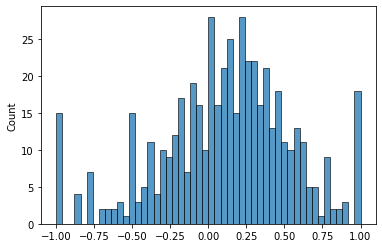

median_gene_crossdataset: 0.14661989847536835


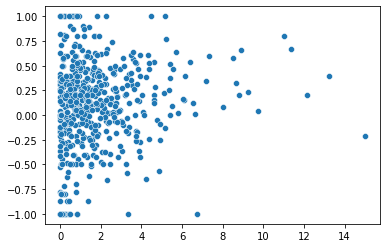

completed epoch 1
duration(mins): 6.752368835608165
patience counter at: 0
hg_train_loss: 1.5781195
hg_val_loss: 1.4987601
hg_val_pearson: 0.48267147
hg_val_R2: [-0.82761586]
mm_val_pearson: 0.50881046
mm_val_R2: [-0.03316045]
overall gene pearsonsR: 0.4826714527118183
overall gene spearmanR: 0.5354085704418248


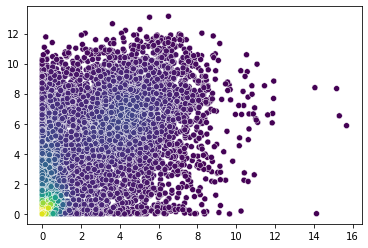

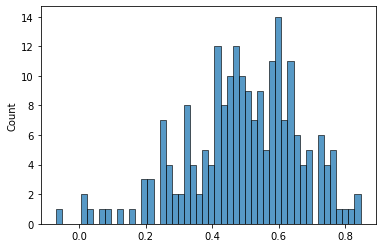

median_cell_crossgenes: 0.5025850598241985


/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


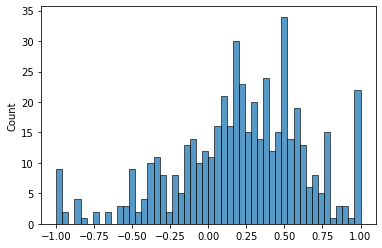

median_gene_crossdataset: 0.2380952380952381


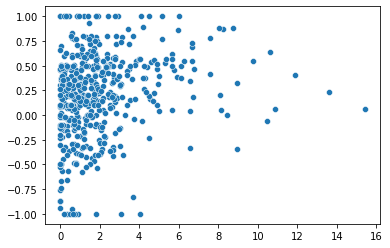

completed epoch 2
duration(mins): 5.535803651809692
patience counter at: 0


In [ ]:
from scipy.stats.stats import pearsonr  
with strategy.scope():
    def sum_log(x):
        return np.log10(1.0 + np.nansum(x))
    
    global_step = 0
    val_losses = []
    val_pearsons = []
    val_R2 = []
    patience_counter = 0
    stop_criteria = False
    best_epoch = 0

    for epoch_i in range(1, 15):
        start = time.time()
        #if epoch_i > 2 : 
        train_step(data_dict_tr['hg'],
                   data_dict_tr['mm'])
                   #data_dict_tr['mm'],
                   #data_dict_tr['rm'])
        print('hg_train_loss: ' + str(metric_dict['hg_tr'].result().numpy()))
        val_step(data_dict_val['hg'], data_dict_val['mm'])

        val_losses.append(metric_dict['hg_val'].result().numpy())
        print('hg_val_loss: ' + str(metric_dict['hg_val'].result().numpy()))
        print('hg_val_pearson: ' + str(metric_dict['hg_corr_stats'].result()['pearsonR'].numpy()))
        print('hg_val_R2: ' + str(metric_dict['hg_corr_stats'].result()['R2'].numpy()))
        
        print('mm_val_pearson: ' + str(metric_dict['mm_corr_stats'].result()['pearsonR'].numpy()))
        print('mm_val_R2: ' + str(metric_dict['mm_corr_stats'].result()['R2'].numpy()))
        
        #print('hg_val_pearson_gene: ' + str(metric_dict['hg_corr_stats'].result()['feature_level_pearsonR'].numpy()))
        #print('hg_val_R2_gene: ' + str(metric_dict['hg_corr_stats'].result()['feature_level_R2'].numpy()))
        
        y_trues = metric_dict['hg_corr_stats'].result()['y_trues'].numpy()
        y_preds = metric_dict['hg_corr_stats'].result()['y_preds'].numpy()
        cell_types = metric_dict['hg_corr_stats'].result()['cell_types'].numpy()
        gene_map = metric_dict['hg_corr_stats'].result()['gene_map'].numpy()

        unique_preds = {}
        unique_trues = {}
        for k,x in enumerate(gene_map):
            unique_preds[(cell_types[k],x)] = y_preds[k]
            unique_trues[(cell_types[k],x)] = y_trues[k]
        
        unique_preds = dict(sorted(unique_preds.items()))
        unique_trues = dict(sorted(unique_trues.items()))
        
        
        print('overall gene pearsonsR:', pearsonr(y_trues,
                                                    y_preds)[0])
        
        print('overall gene spearmanR:', spearmanr(y_trues,
                                                    y_preds)[0])
        data = np.vstack([y_trues,y_preds])
        kernel = stats.gaussian_kde(data)(data)
        sns.scatterplot(
            x=y_trues,
            y=y_preds,
            c=kernel,
            cmap="viridis")
        plt.show()
        
        
        ### now compute correlations across cell types
        across_cells_preds = {}
        across_cells_trues = {}
        
        for k,v in unique_preds.items():
            cell_t,gene_name = k
            if cell_t not in across_cells_preds.keys():
                across_cells_preds[cell_t] = []
                across_cells_trues[cell_t] = []
            else:
                across_cells_preds[cell_t].append(v)
                across_cells_trues[cell_t].append(unique_trues[k])
        cell_specific_corrs = []
        for k,v in across_cells_preds.items():
            trues = []
            preds = []
            for idx,x in enumerate(v):
                preds.append(x)
                trues.append(across_cells_trues[k][idx])
            try: 
                cell_specific_corrs.append(pearsonr(trues, 
                                                    preds)[0])
            except np.linalg.LinAlgError:
                continue
            except ValueError:
                continue
                
        sns.histplot(x=np.asarray(cell_specific_corrs), bins=50)
        plt.show()
        print('median_cell_crossgenes:', np.nanmedian(cell_specific_corrs))
                
            
        ### now compute correlations across genes
        across_genes_preds = {}
        across_genes_trues = {}
        
        for k,v in unique_preds.items():
            cell_t,gene_name = k
            if gene_name not in across_genes_preds.keys():
                across_genes_preds[gene_name] = []
                across_genes_trues[gene_name] = []
            else:
                across_genes_preds[gene_name].append(v)
                across_genes_trues[gene_name].append(unique_trues[k])
        genes_specific_corrs = []
        genes_specific_vars = []
        for k,v in across_genes_preds.items():
            trues = []
            preds = []
            for idx, x in enumerate(v):
                #if len(x) > 0:
                preds.append(x)
                trues.append(across_genes_trues[k][idx])
            try: 
                genes_specific_corrs.append(spearmanr(trues, 
                                                     preds)[0])
                genes_specific_vars.append(np.var(trues))
            except np.linalg.LinAlgError:
                continue
            except ValueError:
                continue
                
        sns.histplot(x=np.asarray(genes_specific_corrs), bins=50)
        plt.show()
        print('median_gene_crossdataset:', np.nanmedian(genes_specific_corrs))
            
        sns.scatterplot(
            x=genes_specific_vars,
            y=genes_specific_corrs)
        plt.show()

        #print('mm_train_loss: ' + str(metric_dict['mm_tr'].result().numpy()))

        #print('mm_val_loss: ' + str(metric_dict['mm_val'].result().numpy()))
        #print('mm_val_pearson: ' + str(metric_dict['mm_corr_stats'].result()['pearsonR'].numpy()))
        #print('mm_val_R2: ' + str(metric_dict['mm_corr_stats'].result()['R2'].numpy()))
        
        end = time.time()
        duration = (end - start) / 60.
        print('completed epoch ' + str(epoch_i))
        print('duration(mins): ' + str(duration))
        print('patience counter at: ' + str(patience_counter))

        for key, item in metric_dict.items():
            item.reset_state()

In [ ]:
model.summary()

In [14]:
test = tf.ones([5,10])
test
pad = tf.constant([[0,0],[1,1]])
tf.pad(test,pad,"CONSTANT",0.0)

<tf.Tensor: shape=(5, 12), dtype=float32, numpy=
array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.]], dtype=float32)>